# Advanced Python ML

This notebook provides a comprehensive demonstration of the ML pipeline, covering all essential steps from data generation to model evaluation and saving. By utilizing a synthetic dataset, we illustrate key concepts and techniques involved in building a robust ML model.

The workflow includes data exploration, model training with hyperparameter tuning, and evaluation using various performance metrics.

**Bonus Features**: Additional functionalities such as cross-validation are implemented to assess model stability, and feature selection is employed to enhance model performance by reducing dimensionality.

**Model Saving**: Finally, the best-performing model is saved for future use, ensuring that the results can be easily accessed and applied in subsequent analyses.


         feature_0    feature_1    feature_2    feature_3    feature_4  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.053827     0.018832    -0.480995     0.020933     0.336366   
std       2.130360     2.095132     1.879645     2.011018     3.542104   
min      -6.865339    -7.030162    -6.227178    -6.184692   -11.421566   
25%      -1.347721    -1.360239    -1.762233    -1.272814    -1.861818   
50%       0.092325     0.125624    -0.561960     0.138819     0.302071   
75%       1.517749     1.410062     0.730689     1.459672     2.679576   
max       7.021821     8.237993     6.903293     6.832418    11.988010   

         feature_5    feature_6    feature_7    feature_8    feature_9  ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean     -0.002051     0.023751    -0.518758     0.318615    -0.477339  ...   
std       0.988013     1.011611     2.104034     2.955660     2.050913  ...   
min      -3.25033

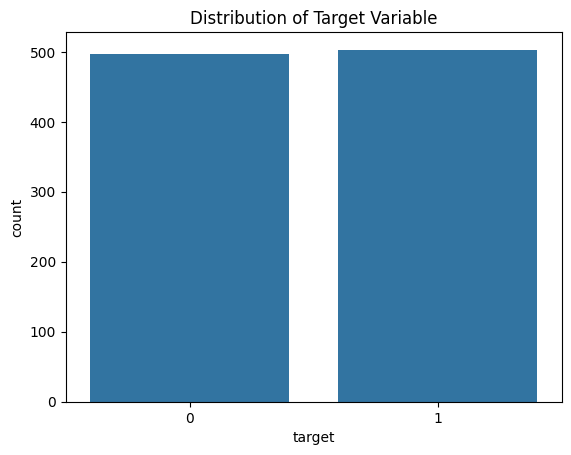

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best Cross-Validation Score: 0.9387
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       102
           1       0.89      0.97      0.93        98

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.92       200
weighted avg       0.93      0.93      0.92       200



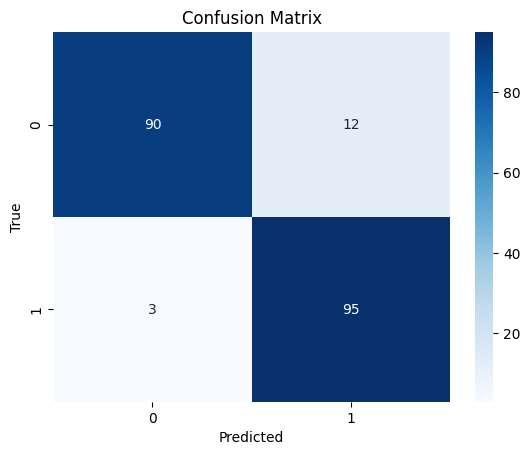

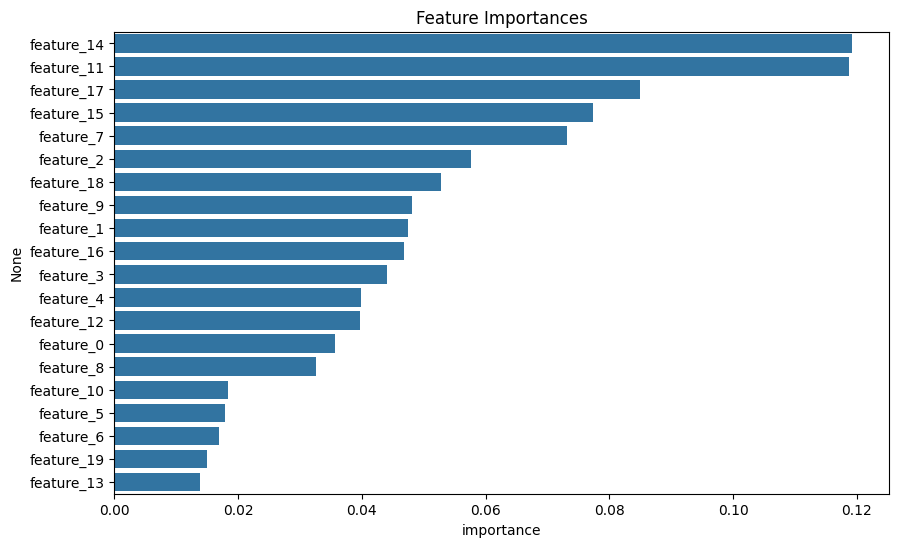

Cross-Validation Scores: [0.95625 0.95625 0.90625 0.9375  0.9375 ]
Mean CV Score: 0.9387


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 36 candidates, totalling 180 fits
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       102
           1       0.87      0.89      0.88        98

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200

Model saved as 'best_random_forest_model.pkl'


In [1]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import joblib  # For saving the model

# Step 2: Generate Synthetic Data
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_redundant=5, random_state=42)
data = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(20)])
data['target'] = y

# Step 3: Data Exploration
print(data.describe())
print(data.isnull().sum())
sns.countplot(x='target', data=data)
plt.title('Distribution of Target Variable')
plt.show()

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], test_size=0.2, random_state=42)

# Step 5: Create a Pipeline with Hyperparameter Tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

# Step 6: Train the Model
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score:.4f}")

# Step 7: Evaluate the Model
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Step 8: Feature Importance
best_model = grid_search.best_estimator_
importances = best_model.named_steps['classifier'].feature_importances_
feature_importances = pd.DataFrame(importances, index=data.columns[:-1], columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Feature Importances')
plt.show()

# Bonus Feature 1: Cross-Validation Scores
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores):.4f}")

# Bonus Feature 2: Feature Selection
selector = SelectFromModel(best_model.named_steps['classifier'], threshold='mean', prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Train a new model on selected features
pipeline_selected = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

grid_search_selected = GridSearchCV(pipeline_selected, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search_selected.fit(X_train_selected, y_train)

# Evaluate the new model
y_pred_selected = grid_search_selected.predict(X_test_selected)
print(classification_report(y_test, y_pred_selected))

# Save the best model
joblib.dump(grid_search.best_estimator_, 'best_random_forest_model.pkl')
print("Model saved as 'best_random_forest_model.pkl'")



### Conclusion

This notebook demonstrates the complete machine learning workflow, highlighting the key steps needed to develop a reliable model. Using a synthetic dataset, we clearly show advanced techniques like hyperparameter tuning and feature selection, which improve model accuracy and interpretability. Cross-validation ensures that the model performs well on unseen data, making it more robust. Finally, saving the best-performing model allows for easy deployment and future use, making this notebook a helpful resource for anyone interested in learning and applying machine learning principles.